# Inicialização

Carregamos a seguir as bibliotecas utilizadas.

In [1]:
# Import de bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pyxlsb import open_workbook as open_xlsb

%matplotlib inline

data_xlsb = '../data/ambev.xlsb'

In [2]:
# Executar se pyxlsb não tiver instalado
#!pip install pyxlsb
#from pyxlsb import open_workbook as open_xlsb

# Leitura/Inspeção dos dados

Realizamos a leitura dos dados como estão, em um dataframe `raw_df`, a partir do arquivo fornecido, em formato `xlsb`.

In [3]:
raw_df = []

with open_xlsb(data_xlsb) as wb:
    for sheetname in wb.sheets:
        with wb.get_sheet(sheetname) as sheet:  
            for row in sheet.rows():
                row_li = [item.v for item in row]
                raw_df.append(row_li)
                
raw_df = pd.DataFrame(raw_df[1:], columns=raw_df[0])

Vejamos as primeiras linhas do dataframe `raw_df`.

In [4]:
raw_df.head()

,Mês Referência,País,Mundo,Regional/Área,Unidade,Grupo Cargo,Cargo,Grade,Banda,Área,...,% Acum Acumulado,% Ating Fim Exer,% Pontos Fim Exer,% Acum Fim Exer,Status Meta,None,None,None,None,None
0,32017.0,Brasil,Sales,10.0,78.0,GER DE VENDAS REVENDA,GERENTE DE VENDAS REVENDA II,12.0,VI-B,GERÊNCIA CD,...,0.0,100.0,100.0,25.0,Monitoramento Aprovado,None,NaN,NaN,NaN,None
1,32017.0,Brasil,Sales,10.0,78.0,GER DE VENDAS REVENDA,GERENTE DE VENDAS REVENDA II,12.0,VI-B,GERÊNCIA CD,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None
2,32017.0,Brasil,Sales,10.0,78.0,GER DE VENDAS REVENDA,GERENTE DE VENDAS REVENDA II,12.0,VI-B,GERÊNCIA CD,...,12.0,100.0,100.0,20.0,Monitoramento Aprovado,None,NaN,NaN,NaN,None
3,32017.0,Brasil,Sales,10.0,78.0,GER DE VENDAS REVENDA,GERENTE DE VENDAS REVENDA II,12.0,VI-B,GERÊNCIA CD,...,12.0,100.0,100.0,15.0,Monitoramento Aprovado,None,NaN,NaN,NaN,None
4,32017.0,Brasil,Sales,10.0,78.0,GER DE VENDAS REVENDA,GERENTE DE VENDAS REVENDA II,12.0,VI-B,GERÊNCIA CD,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None


Há 5 colunas sem nome ao final (`None`). Vamos ver a descrição de `info`.

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270633 entries, 0 to 270632
Data columns (total 38 columns):
Mês Referência           270633 non-null float64
País                     270633 non-null object
Mundo                    270501 non-null object
Regional/Área           270633 non-null float64
Unidade                  270633 non-null float64
Grupo Cargo              230099 non-null object
Cargo                    262118 non-null object
Grade                    262118 non-null float64
Banda                    262118 non-null object
Área                    262116 non-null object
Nome FuncionÁ¡rio        270633 non-null float64
Nome Gestor              270633 non-null float64
Código KPI               230229 non-null object
Diretoria                230229 non-null object
Áreas da Diretoria      230229 non-null object
Função                   230229 non-null object
Tipo da Meta             270633 non-null object
Categoria KPI            267176 non-null object
Nome KPI           

Estas últimas 5 colunas possuem menos de 30 valores preenchidos (de um total de 270633 entradas). As 3 últimas possuem apenas dois valores não-nulos. Isto pode ocorrer por sujeira na base de dados. Vejamos as linhas onde isso ocorre.

In [6]:
raw_df[~raw_df.iloc[:,-1].isna()]

,Mês Referência,País,Mundo,Regional/Área,Unidade,Grupo Cargo,Cargo,Grade,Banda,Área,...,% Acum Acumulado,% Ating Fim Exer,% Pontos Fim Exer,% Acum Fim Exer,Status Meta,None,None,None,None,None
9610,32017.0,Brasil,CE,1.0,275.0,ESPECIALISTA,ESPECIALISTA IV,15.0,V-A,MARKETING,...,100.0,100.0,20.0,100.0,100,20,100.0,100.0,20.0,Monitoramento Aprovado
31343,42017.0,Brasil,CE,1.0,275.0,ESPECIALISTA,ESPECIALISTA IV,15.0,V-A,MARKETING,...,100.0,100.0,20.0,100.0,100,20,100.0,100.0,20.0,Monitoramento Aprovado


In [7]:
raw_df.loc[9610]

Mês Referência                                                      32017
País                                                               Brasil
Mundo                                                                  CE
Regional/Área                                                          1
Unidade                                                               275
Grupo Cargo                                                  ESPECIALISTA
Cargo                                                     ESPECIALISTA IV
Grade                                                                  15
Banda                                                                 V-A
Área                                                           MARKETING
Nome FuncionÁ¡rio                                                     954
Nome Gestor                                                           588
Código KPI                                                      001MK0404
Diretoria                             

Aparentemente houve um "vazamento" da coluna de `Regra Alcance Parcial` para as colunas subsequentes (provavelmente devido a um problema de entrada/*parsing* dos dados em algum momento). Isso é reforçado pelo fato de que as colunas de porcentagem deveriam ser números, não strings. Vejamos a coluna de `Meta Projeto`.

<BarContainer object of 10 artists>

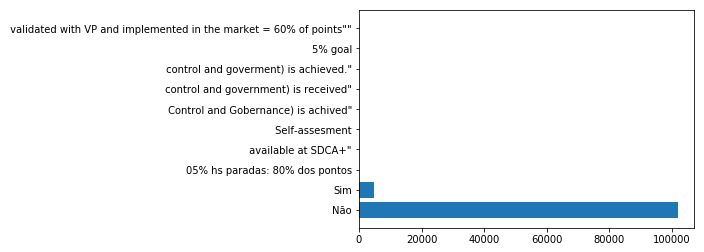

In [8]:
plt.barh(raw_df['Meta Projeto'].value_counts().index, raw_df['Meta Projeto'].value_counts().values)

Vemos que a vasta maioria assume valores 'Sim' ou 'Não', reforçando a hipótese acima. Trataremos disso a seguir, na limpeza dos dados.

# Leitura/Limpeza dos dados

Vamos definir funções auxiliares para realizar a limpeza dos dados.

In [9]:
import unidecode

# Função para substituir espaços por _ (utilizado nos nomes de colunas)
def str_replace_spaces(input_str):
    if input_str == None: return None
    else: return input_str.replace(' ','_')

# Função para 'sanitizar' strings, substituindo erros inseridos por encoding
def str_sanitize(input_str):
    if not (isinstance(input_str,str)):
        return input_str
    
    output_str = input_str.replace('Á¡', 'á')
    
    return unidecode.unidecode(output_str)

# Função que recebe valores de uma linha 'suja' (com valores de Regra Alcance Parcial em mais de uma coluna) 
# e retorna uma linha 'limpa'.
def list_sanitize(input_list):
    output_list = []
    read_val = False
    
    for i, a in enumerate(input_list):
        #print(i)
        #print(val)
        if i == 21: 
            val = a
            if val != None: val = str(val)
        elif i == 22:
            if a != None \
            and not re.search('Sim',a) \
            and not re.search('Não',a):
                read_val = True
                val += " " + a
            else:
                output_list.append(val)
                output_list.append(a)
        
        else:
            if read_val:
                if a == None:
                    read_val = False
                    output_list.append(val)
                    output_list.append(a)
                    
                if re.search('\"$',str(a)):
                    read_val = False
                    val += " " + a
                    output_list.append(val)
                    
                    
            else:
                output_list.append(a)
                
    return output_list

Definidas as funções auxiliares, vamos realizar a leitura dos dados. Note que valores ausentes são preenchidos com `nan`, para evitar valores `None` no dataframe.

In [10]:
df = []

with open_xlsb(data_xlsb) as wb:
    for sheetname in wb.sheets:
        with wb.get_sheet(sheetname) as sheet:  
            for i,row in enumerate(sheet.rows()):
                row_li = [item.v for item in row]
                if (i>0): row_li = list_sanitize(row_li)
                elif (i==0): row_li = [str_sanitize(str_replace_spaces(item)) for item in row_li]
                df.append(row_li)
                
df = pd.DataFrame(df[1:], columns=df[0])
df.fillna(value=np.nan, inplace=True)

Vejamos como ficou o dataframe.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270633 entries, 0 to 270632
Data columns (total 38 columns):
Mes_Referencia           270633 non-null float64
Pais                     270633 non-null object
Mundo                    270501 non-null object
Regional/Area            270633 non-null float64
Unidade                  270633 non-null float64
Grupo_Cargo              230099 non-null object
Cargo                    262118 non-null object
Grade                    262118 non-null float64
Banda                    262118 non-null object
Area                     262116 non-null object
Nome_Funcionario         270633 non-null float64
Nome_Gestor              270633 non-null float64
Codigo_KPI               230229 non-null object
Diretoria                230229 non-null object
Areas_da_Diretoria       230229 non-null object
Funcao                   230229 non-null object
Tipo_da_Meta             270633 non-null object
Categoria_KPI            267176 non-null object
Nome_KPI           

Vemos agora que as últimas colunas agora tem 0 objetos não-nulos. Além disso, as colunas de porcentagens agora foram todas lidas como numéricas, o que é indício de que a leitura está sendo realizada corretamente. Vejamos quais valores temos em `Status Meta`.

In [12]:
df['Status_Meta'].unique()

array(['Monitoramento Aprovado', nan], dtype=object)

Mais um indício: além das colunas de porcentagem puramente numéricas, `Status Meta` tem apenas valores 'Monitoramento Aprovado' e 'None'. Por último, observamos que `Meta Projeto` só possui 3 valores ('Sim', 'Não' e 'None'); e fazemos uma rápida inspeção nos valores em `Regra Alcance Parcial`.

In [13]:
df['Meta_Projeto'].unique()

array(['Não', nan, 'Sim'], dtype=object)

In [14]:
list(df['Regra_Alcance_Parcial'].unique())

['PA1: 99,5% da meta PA2: 99,0% da meta',
 '80% pontos:  -10pp vs Bgt',
 'PA1: 80% = 80% pts PA2: 60% = 60% pts',
 'PA1: 95%_x000D_ PA2: 90%',
 '80% pontos: 97,5% da meta',
 'Regra da Lacuna: Lacuna = (Real - Real AA)/(Meta - Real AA) -> 90% lacuna = 80% pontos',
 '100%: LTI (area) = 0 e LTI Fab <= Bgt e TRI (area) <= Bgt 60%: LTI (area) = 0 e TRI Area < LY e TRI (fÁ¡brica) <= Bgt Se ocorrer acidente fatal típico = zero.',
 '100% GLY Area + GLY Linha',
 'Conforme Matriz de Metas VPO 2017 disponível no SDCA+',
 '100% meta atingida em aço e PVC , 60% meta atingida em aço',
 nan,
 'Orgânico: 100% meta = 100% pontos',
 'Projeto 4 KPIs: 4 KPIs = 100% pontos',
 '4 milestones ? 100% dos pontos',
 'Volume real até 90% do orçamento = 80% dos pontos',
 'De 95% a 100% = 100% pontos, de 90% a 94,99% = 80% pontos, de 85% a 89,99% = 60% pontos',
 '100% <= prazo definido PA1 90% <= 2 semanas de atraso PA2 80% <= 4 semanas de atraso d) 0% Achievement > 4 semanas de atraso',
 '100%: LTI e TRI act <= bg

## Limpeza restante

De início, vamos eliminar as colunas ao final, sem valor algum.

In [15]:
df.drop(df.columns[-5:-1],axis=1,inplace=True)

Vamos analisar a coluna `Mes Referencia`:

In [16]:
df['Mes_Referencia'].unique()

array([  32017.,   42017.,   52017.,   62017.,   72017.,   82017.,
         92017.,  102017.,  112017.,  122017.])

Uma vez que o nome da coluna faz menção a data, vamos interpretar os valores como sendo meses no ano de 2017.

In [17]:
df['Mes_Referencia'] = pd.to_datetime(df['Mes_Referencia'], format='%m%Y.0')

Vamos analisar os valores nas demais colunas, a fim de decidir se é necessário realizar alguma limpeza adicional. Vejamos as colunas que possuem no máximo 150 valores únicos.

In [18]:
c = 0
t = 0

for col in df.columns:
    if (df[col].dtype=='O'):
        t += 1
        if (df[col].nunique() < 150):
            c += 1
            print('* ' + col)
            print(df[col].unique())
            
print(str(c) + " colunas de um total de " + str(t))

* Pais
['Brasil' 'Barbados' 'Cuba' 'Dominica' 'Guatemala' 'PanamÁ¡'
 'Rep. Dominicana' 'Saint Vincent' 'Panama']
* Mundo
['Sales' 'Supply' 'CE' 'DG' nan 'Logisitca' 'Finance' 'People'
 'Asuntos Corporativos' 'Compras' 'Integración' 'Marketing' 'Solutions'
 'HILA - Proceso de Ventas' 'Sales - Finanzas' 'Sales - Gente y Gestión'
 'Sales - Operaciones' 'Sales - Trade Marketing' 'Sales - Ventas'
 'Sales - Cadena de Abastecimiento & TI' 'Sales - Marketing' 'Caribe Ex'
 'HILA â¬ \x1c  Suministros' 'Sales - International' 'Sales - Legal'
 'Sales - Proyectos y TI' 'Sales - Sumistros' 'Supply - Planta CND'
 'Supply - Planta HN' 'Comercial' 'Supply - Planta Habana']
* Grupo_Cargo
['GER DE VENDAS REVENDA' 'SUPERVISOR FABRIL' 'ESPECIALISTA'
 'GER ENGENHARIA' 'COORD' 'GER OPERAçÁ" ES DISTRIB ROTA' 'COORD FABRIL'
 'ANALISTA FABRIL' 'GER OPERAçÁ" ES E DISTRIB' 'ENGENHEIRO FABRIL'
 'SECRETÁ\x81RIA DIRETORIA' 'SUPERVISOR' 'GER DE VENDAS ROTA'
 'GER PRODUçãO CERVEJA' 'GER COMERCIAL ROTA' 'GREG LOGÁ\x8dS

['Não' nan 'Sim']
* Status_Meta
['Monitoramento Aprovado' nan]
13 colunas de um total de 16


Criamos um dicionário para substituir erros na codificação, e definimos uma função para realizar a limpeza adicional.

In [19]:
replace_dict = {'Áµ':'õ',
                'Ã`\x01': 'Ê',
                'Ã\x8d': 'Í',
                'Ã! ':'Ç',
                'Ã\x92\x01O': 'ÃO',
                'Á\x1d ': 'Ô',
                'Á\x1c': 'Ó', 
                'Á\x8d': 'Í',
                'Â\xa0': ' ',
                '\x81':'',
                'â¬ \x1c ': '-', 
                'Á¡':'á',
                'Ã©': 'é',
                'Ã\xad': 'í',
                'Ã\x1c': 'Ó',
                'Ã£': 'ã',
                'ARMAZÁ0 M': 'ARMAZÉM',
                'OPERAçÁ" ES': 'OPERAçÕES',
                'Logisitca': 'Logistica',
                'Sumistros': 'Suministros',
                'GREG': 'GER'
               }

def str_clean(x):
    if x == None or not isinstance(x,str): return x
    for item in replace_dict:
        if item in x:
            x = x.replace(item,replace_dict[item])
            
    return unidecode.unidecode(x).strip()

Aplicamos a função aos campos que têm string.

In [20]:
for col in df.columns:
    if (df[col].dtype=='O'):
        df[col] = df[col].apply(lambda x : str_clean(x))

In [21]:
cols = ['Grupo_Cargo', 'Area', 'Funcao', 'Categoria_KPI']
for col in cols:
    df[col] = df[col].apply(lambda x : x.title() if isinstance(x,str) else x)

Vejamos as strings mais similares nas mesmas features (com até 150 valores únicos), para dar-nos pistas sobre valores que devem ser modificados ou ajustados.

In [22]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

for col in df.columns:
    if (df[col].dtype=='O') and (df[col].nunique() < 150):
        print('* ' + col)
        enum = list(enumerate(df[col].unique()))
        for i, a in enum:
            for j,b in enum:
                if (j > i) and (isinstance(a,str)) and (isinstance(b,str)) and (similar(a,b) > 0.7):
                    print("(" + str(i) + "," + str(j) + ") " + a + ", " + b)
                    
            

* Pais
* Mundo
(14,18) Sales - Finanzas, Sales - Ventas
(17,20) Sales - Trade Marketing, Sales - Marketing
(18,24) Sales - Ventas, Sales - Legal
(22,26) HILA - Suministros, Sales - Suministros
(27,28) Supply - Planta CND, Supply - Planta HN
(27,30) Supply - Planta CND, Supply - Planta Habana
(28,30) Supply - Planta HN, Supply - Planta Habana
* Grupo_Cargo
(0,12) Ger De Vendas Revenda, Ger De Vendas Rota
(0,53) Ger De Vendas Revenda, Ger De Vendas As
(0,126) Ger De Vendas Revenda, Ger De Vendas Vip
(1,11) Supervisor Fabril, Supervisor
(1,109) Supervisor Fabril, Supervisor Vendas
(2,44) Especialista, Especialista G&G
(2,75) Especialista, Especialista Refri
(2,79) Especialista, Advogado Especialista
(3,120) Ger Engenharia, Gcorp Engenharia
(5,8) Ger Operacoes Distrib Rota, Ger Operacoes E Distrib
(5,63) Ger Operacoes Distrib Rota, Ger Operacoes Distrib As
(7,115) Analista Fabril, Analista Rota
(8,63) Ger Operacoes E Distrib, Ger Operacoes Distrib As
(8,91) Ger Operacoes E Distrib, Ger Ope

(4,85) Projetos/ Iniciativas De Longo Prazo/ Estrategia, Proyectos / Iniciativas A Largo Plazo / Estrategia
(4,91) Projetos/ Iniciativas De Longo Prazo/ Estrategia, Proyectos/ Iniciativas A Largo Plazo/ Estrategia
(5,90) Mundo Melhor, Mundo Mejor
(6,61) Gente E Gestao, Gente Y Gestion
(8,87) Cash Flow, Cashflow
(9,110) Inovacoes/ Projeto De Inovacoes, Innovaciones / Proyecto De Innovaciones
(10,94) Imagem Da Marca (Brandhealth), Imagen De La Marca (Brandhealth)
(11,23) Market Share/ Volume Brewed, Market Share / Volume
(11,25) Market Share/ Volume Brewed, Market Share/ Volume Phd
(11,35) Market Share/ Volume Brewed, Market Share/ Volumen
(11,49) Market Share/ Volume Brewed, Market Share / Volumen
(12,22) Profitability / Costs (Maco, Vic, Vlc, Ebitda, Efficiency And Productivity), Profitability/ Cost (Maco, Vic, Vlc, Ebitda, Eficiency And Productivity)
(12,28) Profitability / Costs (Maco, Vic, Vlc, Ebitda, Efficiency And Productivity), Profitability/ Costs (Maco, Vic, Vlc, Ebitda, Efici

Podemos reparar algumas ainda sujeiras/typos, que são corrigidas na função abaixo.

In [23]:
replace_dict_cat = {
    'Area': [
        ['E-Commerce', 'Ecommerce'],
        ['Projeto', 'Projetos']
    ],
    
    'Funcao': [
        ['Gerente Financeiro', 'Ger Financeiro']
    ],
    
    'Categoria_KPI': [
        ['Imagen De Mnarca', 'Imagen De Marca'],
        ['Machine Kpis', 'Machine Kpi'],
        ['Cash Flow','Cashflow'],
        ['Project Kpi', 'Project'],
        ['Le Accurancy', 'Le Accuracy'],
        ['Legal Compliance', 'Compliance'],
        ['Gestio N Recursos Marcas', 'Gestion Recursos Marcas']
        
    ],
    
    
    'Prazo': [
        ['monthly', 'Monthly'],
        ['Monthly basis', 'Monthly'],
        ['monthly basis', 'Monthly']
    ]
}

def str_refinement(df):
    for cat in replace_dict_cat:
        for [str_from,str_to] in replace_dict_cat[cat]:
            df[cat].replace(str_from,str_to,inplace=True)
            
str_refinement(df)

Notamos ainda que a feature `Categoria_KPI` possui diversas versões para a mesma categoria (como 'Market Share/ Volumen' e 'Market Share / Volumen'). Para facilitar a análise, vamos agrupar estas categorias similares, de forma automatizada.

Na abordagem abaixo, intuitivamente, formamos um DAG (*Directed Acyclic Graph*) com as substituições/semelhanças sugeridas, onde os elementos de maior índice apontam para os de menor.

In [24]:
# Função para agrupar as diferentes versões de strings em uma coluna
def str_similarity_replacement(df,col):
    replacement_dict = {}
    
    enum = list(enumerate(df[col].unique()))
    for i, a in enum:
        for j,b in enum:
            if (j > i) and (isinstance(a,str)) and (isinstance(b,str)) and (similar(a,b) > 0.7):
                if b not in replacement_dict: replacement_dict[b] = a
                
    for b in replacement_dict:
        a = replacement_dict[b]
        while (a in replacement_dict):
            a = replacement_dict[a]
        replacement_dict[b] = a
        
    for b in replacement_dict:
        df[col].replace(b, replacement_dict[b],inplace=True)
        
        
str_similarity_replacement(df,'Categoria_KPI')

O agrupamento poupa algum trabalho, mas ainda há um trabalho de limpeza, além de tradução (como 'Inovacoes/ Projeto De Inovacoes' e 'Innovations / Innovations Project') a ser realizado, como vemos a seguir.

In [25]:
df['Categoria_KPI'].unique()

array(['Market Share/ Volume', 'Qualidade', 'Melhoria Continua',
       'Rentabilidade/ Custos (Maco, Vic, Vlc, Ebitda, Eficiencia E Produtividade)',
       'Projetos/ Iniciativas De Longo Prazo/ Estrategia', 'Mundo Melhor',
       'Gente E Gestao', 'Obz', 'Cashflow',
       'Inovacoes/ Projeto De Inovacoes', 'Imagem Da Marca (Brandhealth)',
       'People & Management', 'Continuous Improvement', 'Zbb', 'Quality',
       'Innovations / Innovations Project', 'Compliance', 'Better World',
       'Shelf Space Increase / Brewed Alcohol',
       'Long-Term Projects / Initiatives / Strategy', 'Productivity',
       'Service Level', 'Safety', 'Cost', 'Dpo', 'People', nan,
       'Brand Health', 'Synergies', 'Package Risk & Opportunities', 'Mics',
       'Bad Debt', 'Le Accuracy', 'Project', 'Medium Term Planning (P3M)',
       'Generic', 'Proyecto Oceano', 'Sales & Mkt Package Roi', 'Gestion',
       'Reputacion', 'Volumen', 'Digital Results',
       'Gestion Recursos Marcas', 'Green Belt', '

Este trabalho é realizado quase que manualmente a seguir. Na tradução, além das modificações mais óbvias:

- Consideramos 'volumen' como volume em *market share*
- EBITDA e 'Productivity' foram classificados em 'Rentabilidade/Custos'
- Categorias com OBZ e ZBB foram classificadas em 'OBZ' (considerando que OBZ se refere a 'Orçamento base zero', ou 'Zero based budgeting'

In [26]:
def sanitize_cat_kpi(df):
    col = 'Categoria_KPI'
    
    df[col] = df[col].apply(lambda x: re.sub(r'\s*/\s*', r'/', x).strip() if isinstance(x,str) else x)
    
    replace_dict = {
        'Continuous Improvement': 'Melhoria Continua',
        'People & Management': 'Gente E Gestao',
        'Imagem Da Marca (Brandhealth)': 'Imagem Da Marca',
        'Brand Health' : 'Imagem Da Marca',
        'Innovations/Innovations Project': 'Inovacoes/Projeto De Inovacoes',
        'Quality': 'Qualidade',
        'Imagen De Marca': 'Imagem Da Marca',
        'Rentabilidade/Custos (Maco, Vic, Vlc, Ebitda, Eficiencia E Produtividade)': 'Rentabilidade/Custos',
        'Rentabilidad/Costos': 'Rentabilidade/Custos',
        'Better World' : 'Mundo Melhor',
        'Innovaciones': 'Inovacoes/Projeto De Inovacoes',
        'Profit/Costs (Maco,Vic, Vlc, Ebitda..)': 'Rentabilidade/Custos',
        'Long-Term Projects/Initiatives/Strategy': 'Projetos/Iniciativas De Longo Prazo/Estrategia',
        'Volumen': 'Market Share/Volume',
        'Ebitda': 'Rentabilidade/Custos',
        'Productivity': 'Rentabilidade/Custos',
        'Cost': 'Rentabilidade/Custos',
        'Gestion': 'Gente E Gestao',
        'Sinergias Caribe': 'Sinergias',
        'Synergies': 'Sinergias',
        'People': 'Gente E Gestao',
        'Reputacion': 'Imagem Da Marca',
        'Project': 'Projetos/Iniciativas De Longo Prazo/Estrategia',
        'Safety': 'Seguranca',
        'Seguridad': 'Seguranca',
        'Obz': 'OBZ',
        'Zbb': 'OBZ',
        'Obz Incentivos': 'OBZ',
        'Reporte De Carga Tendencias Obz': 'OBZ',
        'Vpo Sustentable - Management And People Pilar': 'Gente E Gestao',
        'Dpo': 'DPO',
        'Machine Kpi': 'Machine KPI',
        'Rojo+Negro Equipo Frio': 'Equipo Frio',
        'Reporte Equipo Frio Rojo+Negro': 'Equipo Frio',
        'Asistente De Nomica': 'Cashflow',
        'Cumplimiento': 'Compliance'
    }
    
    for a in replace_dict:
        df[col].replace(a, replace_dict[a], inplace=True)
    
    
    
    
sanitize_cat_kpi(df)

In [27]:
list(df['Categoria_KPI'].unique())

['Market Share/Volume',
 'Qualidade',
 'Melhoria Continua',
 'Rentabilidade/Custos',
 'Projetos/Iniciativas De Longo Prazo/Estrategia',
 'Mundo Melhor',
 'Gente E Gestao',
 'OBZ',
 'Cashflow',
 'Inovacoes/Projeto De Inovacoes',
 'Imagem Da Marca',
 'Compliance',
 'Shelf Space Increase/Brewed Alcohol',
 'Service Level',
 'Seguranca',
 'DPO',
 nan,
 'Sinergias',
 'Package Risk & Opportunities',
 'Mics',
 'Bad Debt',
 'Le Accuracy',
 'Medium Term Planning (P3M)',
 'Generic',
 'Proyecto Oceano',
 'Sales & Mkt Package Roi',
 'Digital Results',
 'Gestion Recursos Marcas',
 'Green Belt',
 'Reporte Biblia',
 'Rankings',
 'Ejecucion De Sdg',
 'Equipo Frio',
 'Reporte De Gastos Mensual',
 'Pago De Incentivos',
 'Share',
 'Dominio',
 'Sep',
 'Cobertura',
 'Vol Gt',
 'Som',
 'Business Disruption',
 'Pro-Business',
 'Sales',
 'Planes Trade',
 'Business Cycle Adherence',
 'Alcance Gps',
 '#3 Mejoras Area Techsales',
 'Gestion A La Vista 2.0',
 'Sistema Mercaderista',
 'M&A',
 'Relationship',
 'Machi

E aqui encerramos a etapa de Limpeza/Manipulação dos dados.